In [3]:
import baccoemu
import chainconsumer
import emcee
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import warnings

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plot_utils
import plotter
import utils
import run_inference as rinf
import moment_network as mn

%load_ext autoreload
%autoreload 2

2024-03-19 13:47:50.426514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Results

In [5]:
plot_dir = '../plots/plots_2024-03-15'
save_plots = True

data_mode = 'emuPk'
tag_data = '_2param'
tag_errG = f'_boxsize500'
tag_inf = '_'+data_mode + tag_data + tag_errG
dir_mn = f'../data/results_moment_network/mn{tag_inf}'


In [6]:
if data_mode == 'emuPk':
    frac_train=0.4
    frac_val=0.1
    frac_test=0.5
    
elif data_mode == 'muchisimocks':
    frac_train=0.70
    frac_val=0.15
    frac_test=0.15

In [7]:
dir_data = '../data/emuPks'
rng = np.random.default_rng(42)

n_tot = 2000
theta, y, y_err, k, param_names = rinf.load_data_emuPk(dir_data, tag_data, tag_errG, rng=rng)
if n_tot < theta.shape[0]:
    theta, y, y_err = rinf.subsample_data(theta, y, y_err, n_tot, rng=rng)
n_tot, n_params = theta.shape

random_ints = np.arange(n_tot)
rng.shuffle(random_ints) #in-place

idxs_train, idxs_val, idxs_test = utils.idxs_train_val_test(random_ints, 
                                frac_train=frac_train, frac_val=frac_val, frac_test=frac_test)

theta_train, theta_val, theta_test = utils.split_train_val_test(theta, idxs_train, idxs_val, idxs_test)
y_train, y_val, y_test = utils.split_train_val_test(y, idxs_train, idxs_val, idxs_test)
y_err_train, y_err_val, y_err_test = utils.split_train_val_test(y_err, idxs_train, idxs_val, idxs_test)

(10000, 2) (10000, 30) (30,) (10000, 30)
0.4 0.1 0.5


In [8]:
param_labels = [utils.param_label_dict[param_name] for param_name in param_names]

In [9]:
theta_test_pred = np.load(f'{dir_mn}/theta_test_pred.npy')
covs_test_pred = np.load(f'{dir_mn}/covs_test_pred.npy')
print(theta_test_pred.shape, covs_test_pred.shape)

(1000, 2) (1000, 2, 2)


In [10]:
# moment_network = mn.MomentNetwork(tag_mn=tag_inf)
# moment_network.load_model_mean()
history_mean = np.load(f'{dir_mn}/model_mean_history.npy', allow_pickle=True).item()
history_cov = np.load(f'{dir_mn}/model_cov_history.npy', allow_pickle=True).item()

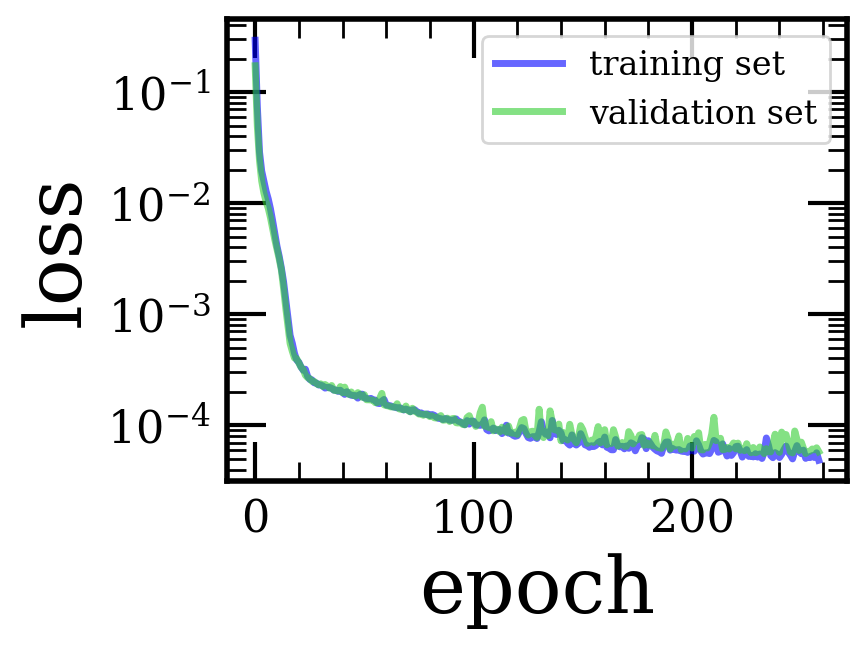

In [11]:
plotter.plot_loss(history_mean)

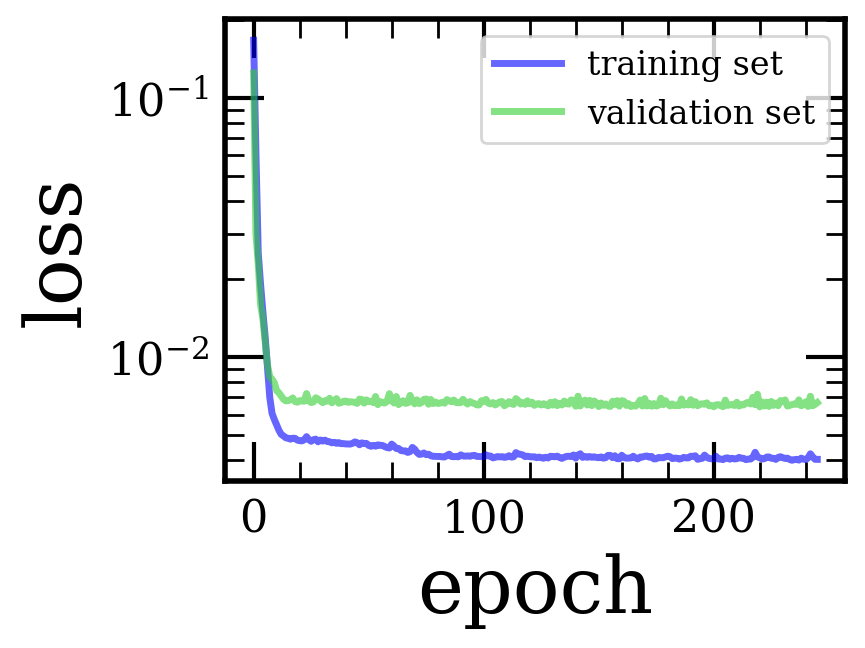

In [12]:
plotter.plot_loss(history_cov)

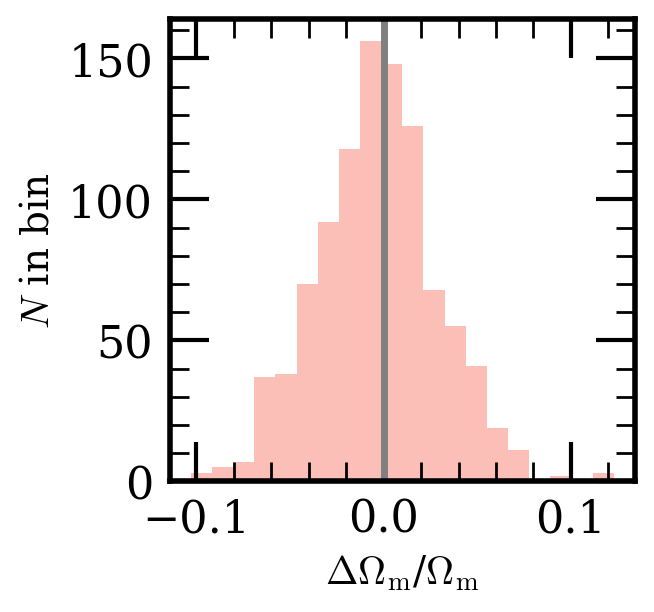

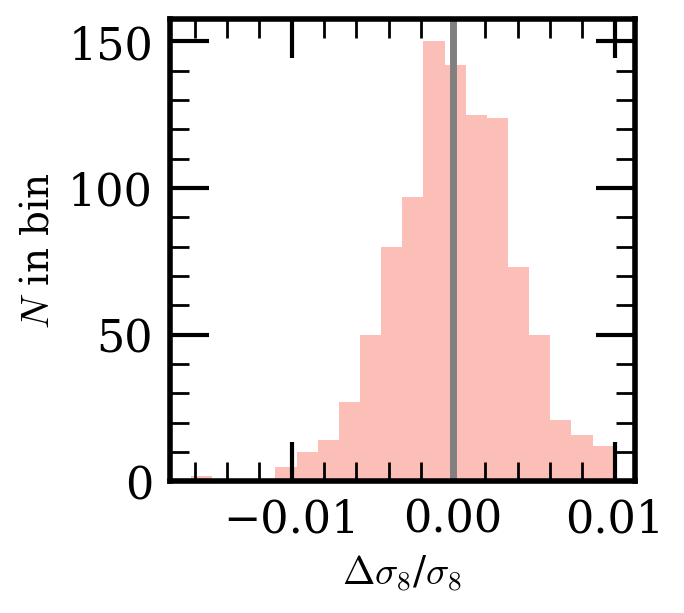

In [13]:
fracdiffs = (theta_test_pred - theta_test)/theta_test
plotter.plot_hists_mean(fracdiffs, param_labels)


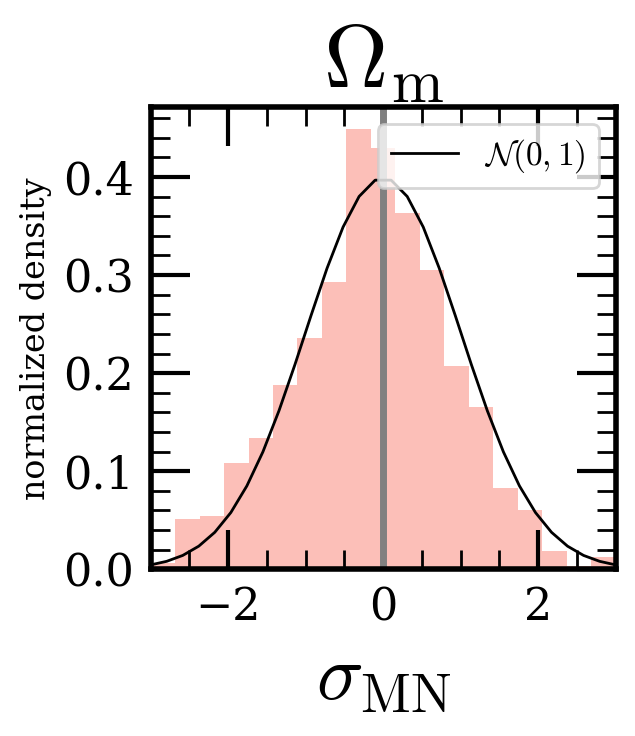

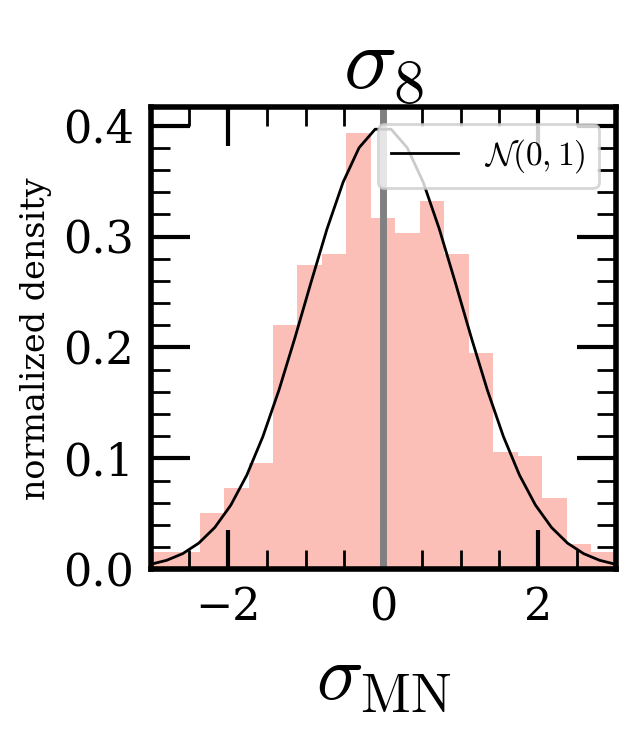

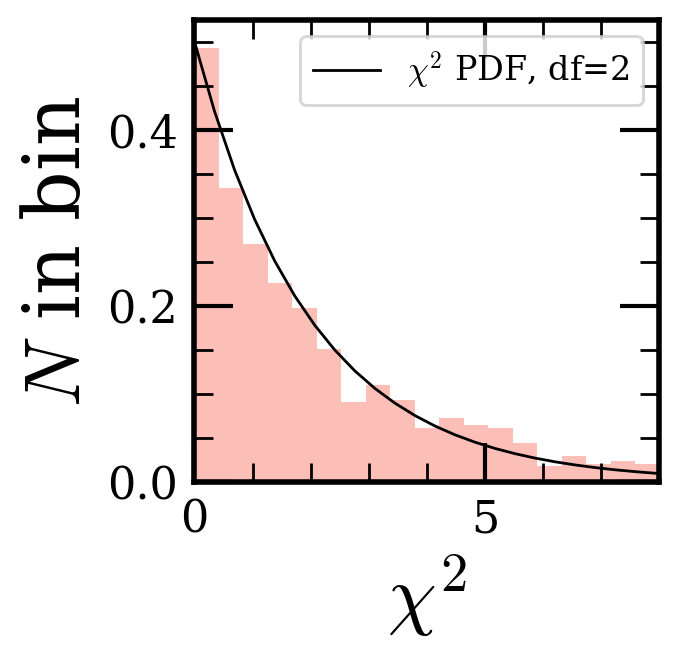

In [14]:
plotter.plot_hists_cov(theta_test, theta_test_pred, covs_test_pred, param_labels)

### Particular test sample

In [14]:
idx_test = 130

In [39]:
smooth_dict = {'mn': 1, 'emcee': 2, 'dynesty': 2}
bins_dict = {'mn': None, 'emcee': 10, 'dynesty': 7}

def plot_results(idx_test, methods, tags_inf, colors=None, labels=None):
    print(idx_test)
    title = f'test model {idx_test}'
    truth_loc = dict(zip(param_names, theta_test[idx_test]))

    samples_arr = []
    for i, method in enumerate(methods):
        if method=='mn':
            try:
                samples_mn = rng.multivariate_normal(theta_test_pred[idx_test], 
                                                    covs_test_pred[idx_test], int(1e6),
                                                    check_valid='raise')
            except ValueError:
                title += f' [$C$ not PSD!]'
                samples_mn = rng.multivariate_normal(theta_test_pred[idx_test], 
                                                    covs_test_pred[idx_test], int(1e6),
                                                    check_valid='ignore')
            samples_arr.append(samples_mn)
            
        if method=='emcee':
            dir_emcee =  f'../data/results_emcee/samplers{tags_inf[i]}'
            fn_emcee = f'{dir_emcee}/sampler_idxtest{idx_test}.npy'
            if not os.path.exists(fn_emcee):
                print(f'File {fn_emcee} not found')
                return
            reader = emcee.backends.HDFBackend(fn_emcee)

            tau = reader.get_autocorr_time()
            n_burn = int(2 * np.max(tau))
            thin = int(0.5 * np.min(tau))
            #print(n_burn, thin)
            samples_emcee = reader.get_chain(discard=n_burn, flat=True, thin=thin)
            samples_arr.append(samples_emcee)
            
        if method=='dynesty':
            dir_dynesty =  f'../data/results_dynesty/samplers{tags_inf[i]}'
            fn_dynesty = f'{dir_dynesty}/sampler_results_idxtest{idx_test}.npy'
            results_dynesty = np.load(fn_dynesty, allow_pickle=True).item()
            #samples_dynesty = results_dynesty.samples_equal()
            
            from dynesty.utils import resample_equal
            # draw posterior samples
            weights = np.exp(results_dynesty['logwt'] - results_dynesty['logz'][-1])
            samples_dynesty = resample_equal(results_dynesty.samples, weights)

            samples_arr.append(samples_dynesty)


    smooth_arr = [smooth_dict[method] for method in methods]
    bins_arr = [bins_dict[method] for method in methods]
    if colors is None:
        colors = [utils.color_dict_methods[meth] for meth in methods]
    if labels is None:
        labels = [utils.label_dict_methods[meth] for meth in methods]

    plotter.plot_contours(samples_arr, labels, colors, param_names, utils.param_label_dict, 
                        smooth_arr=smooth_arr, bins_arr=bins_arr,
                        truth_loc=truth_loc, title=title, extents={}, fn_save=None)


6


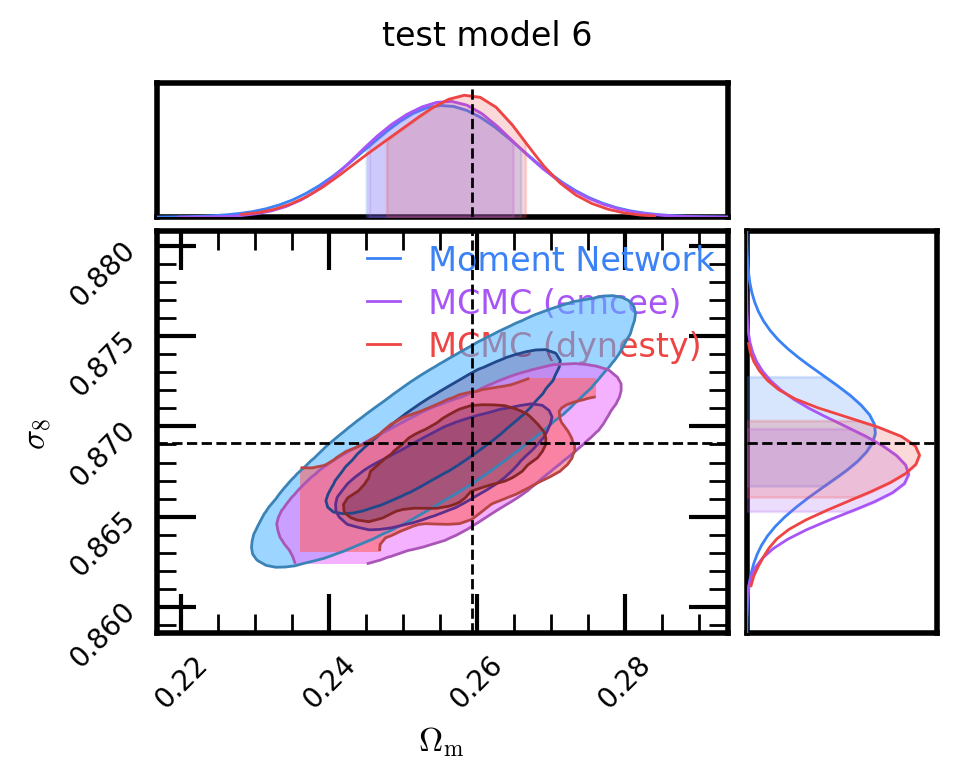

In [120]:
methods = ['mn', 'emcee', 'dynesty']
idx_test = 6
plot_results(idx_test, methods)


6


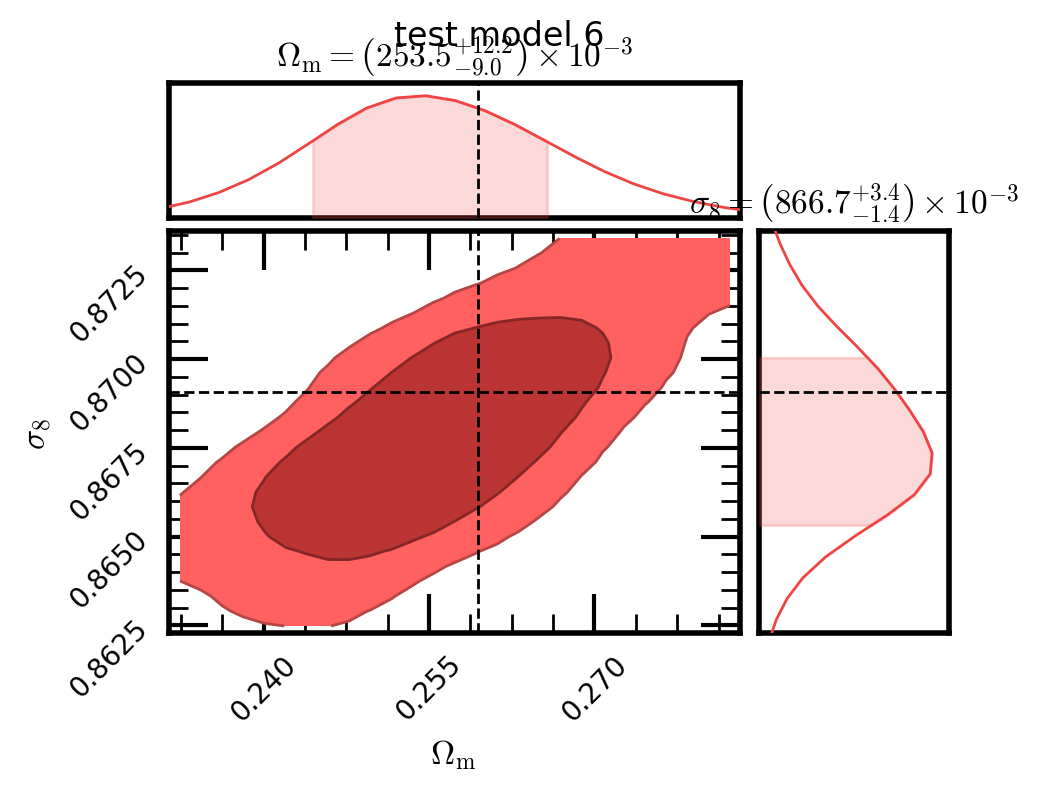

In [122]:
methods = ['dynesty']
idx_test = 6
#tag_inf += '_nlive50'
plot_results(idx_test, methods)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


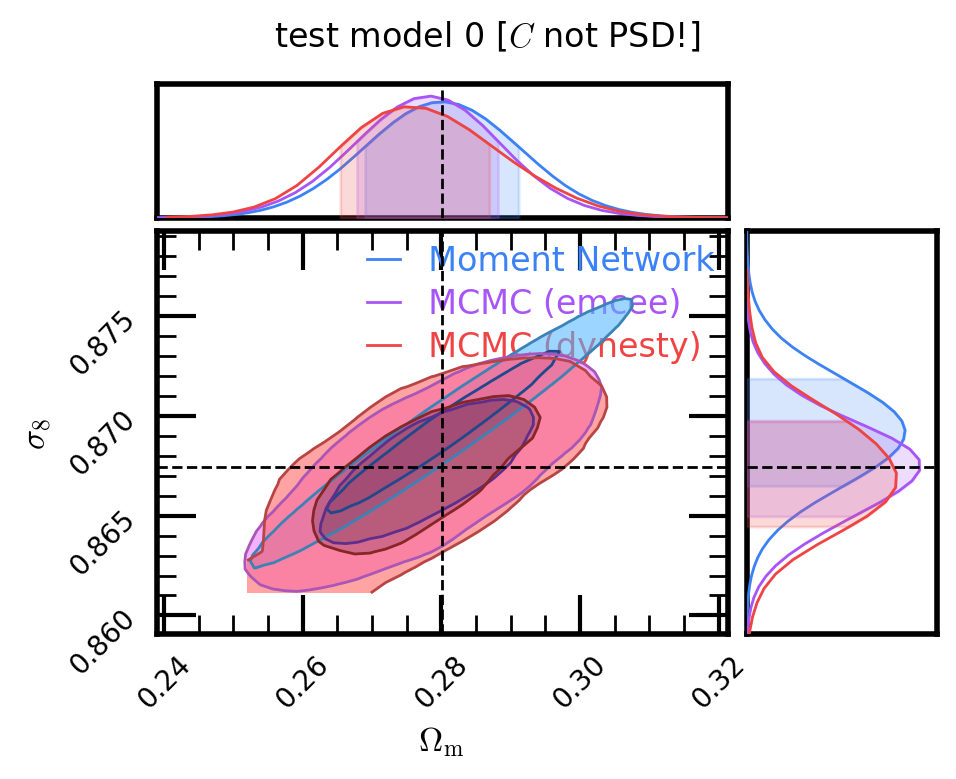

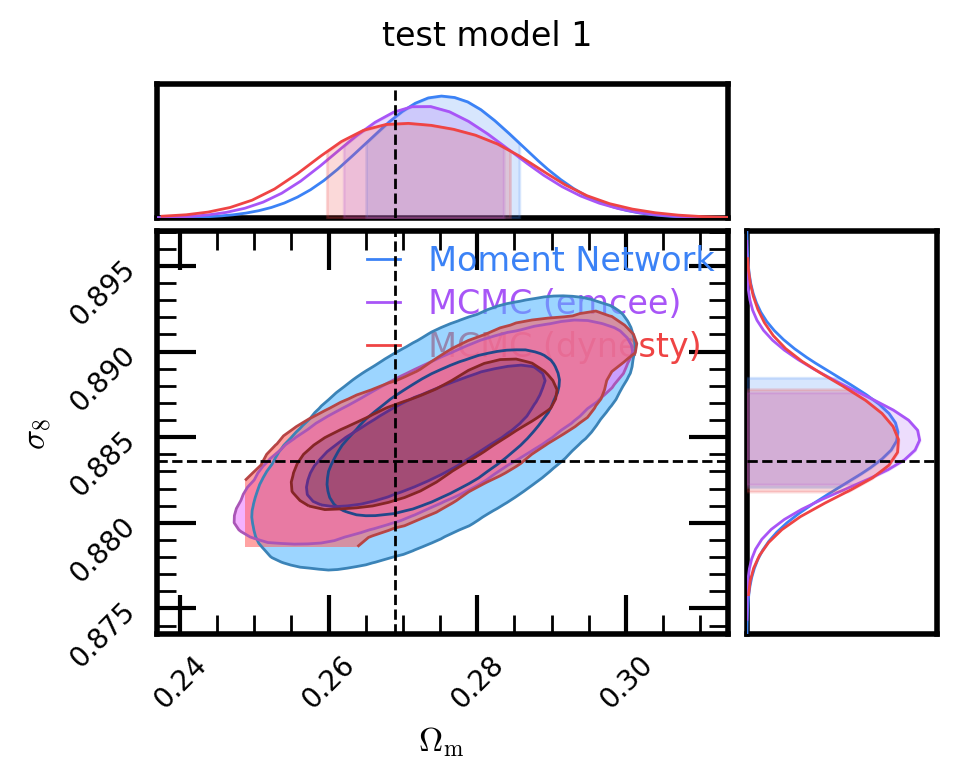

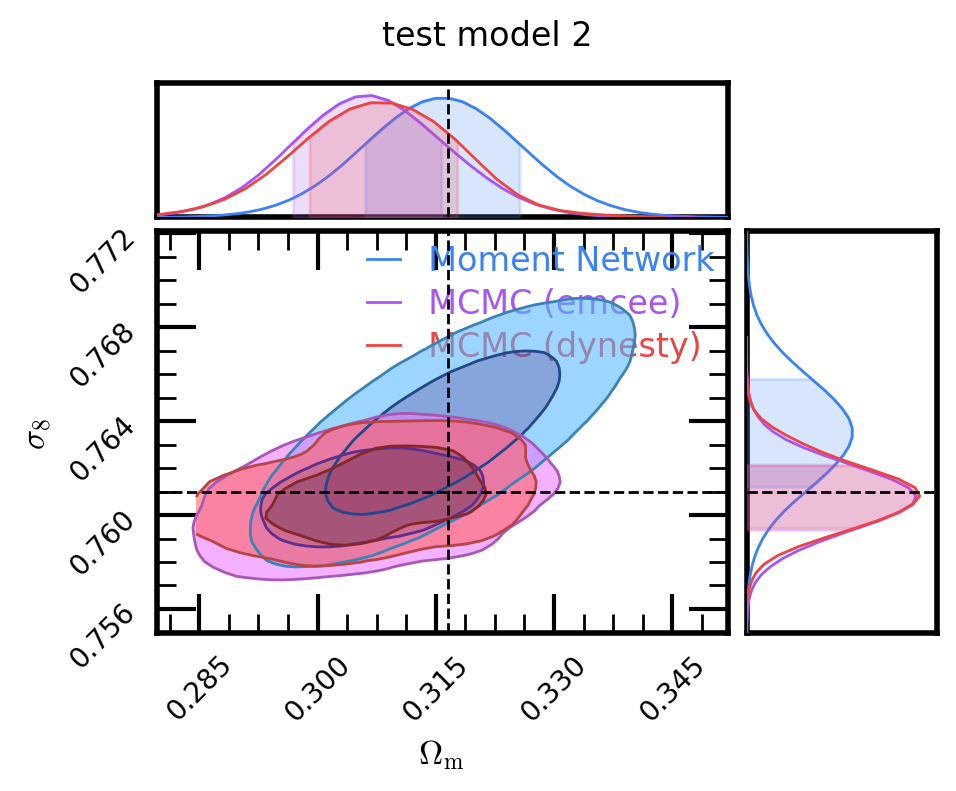

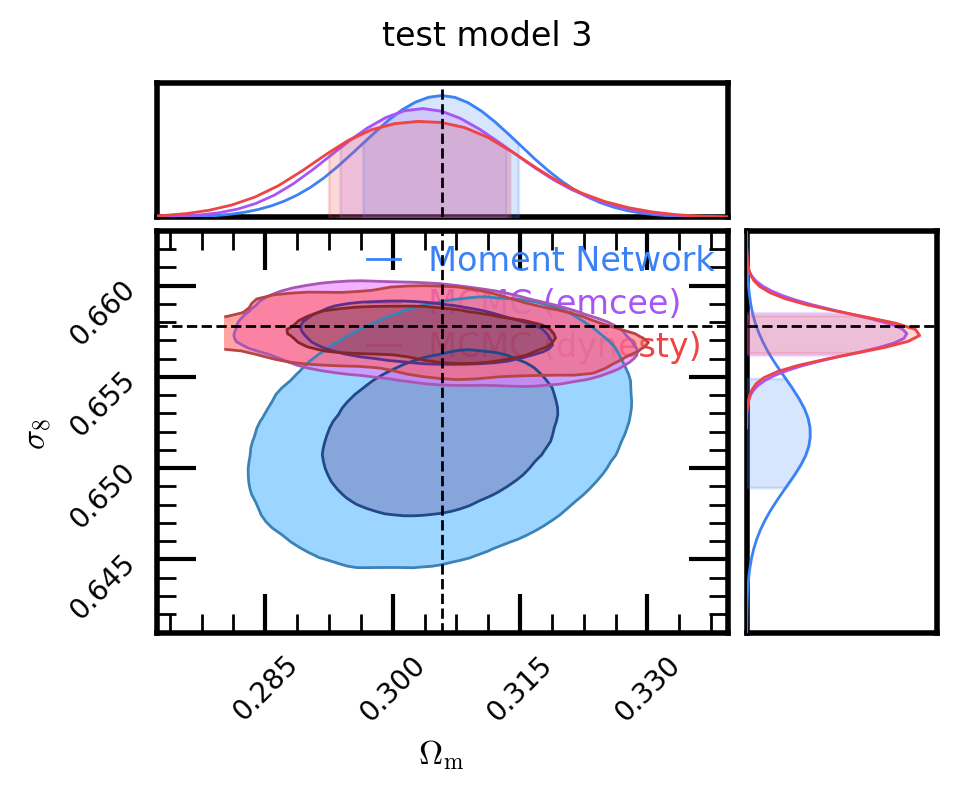

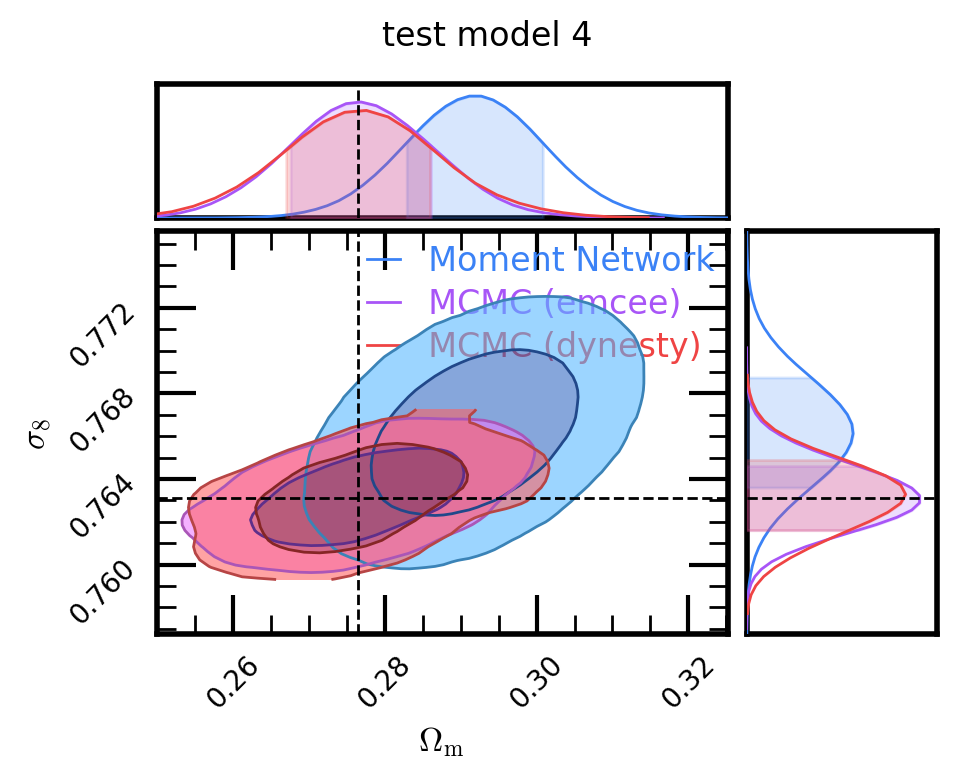

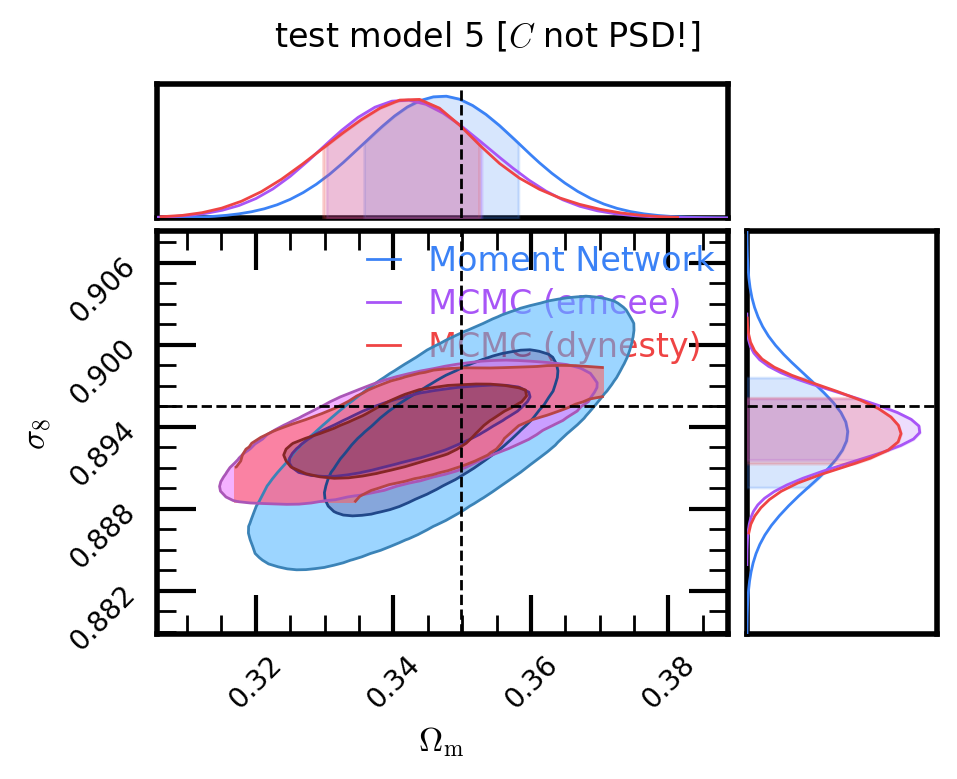

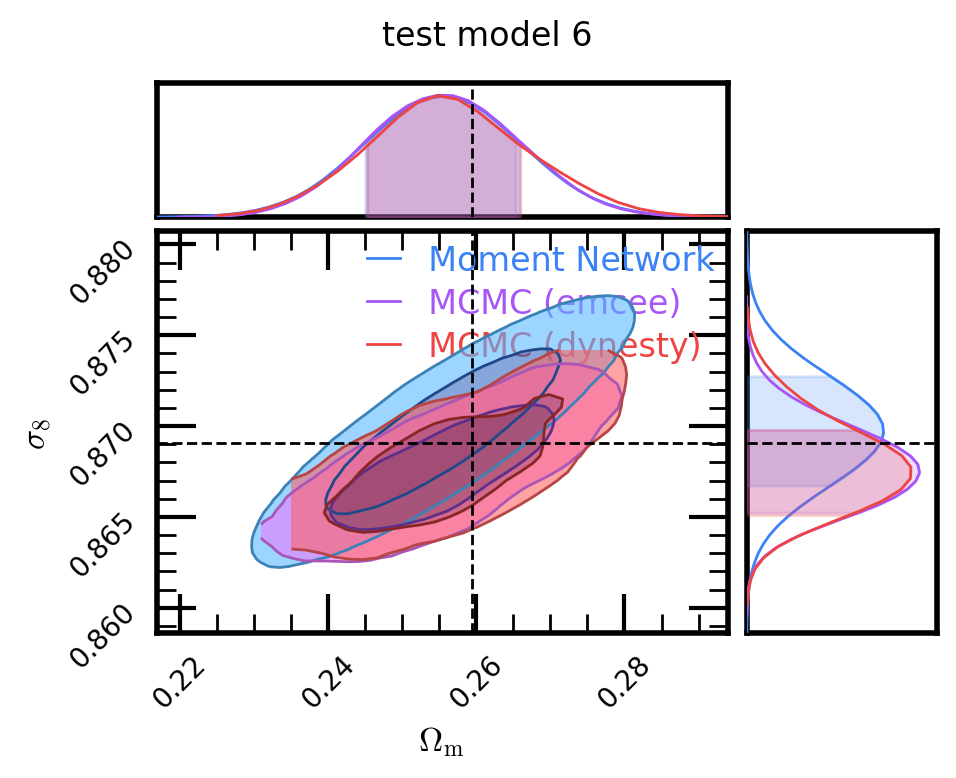

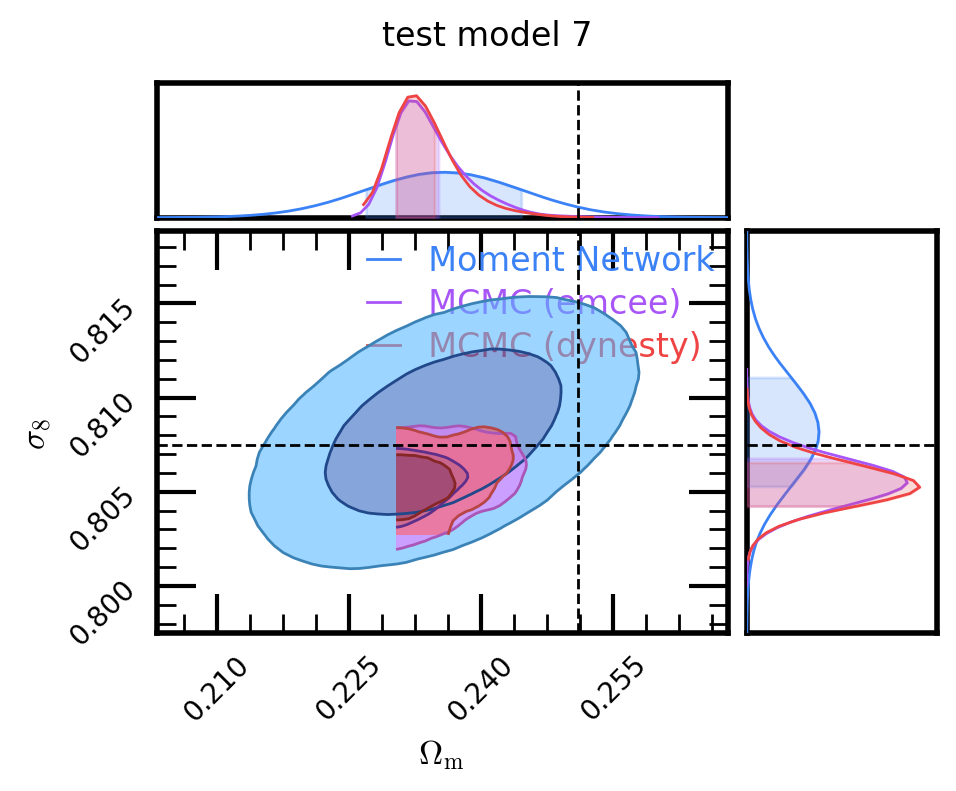

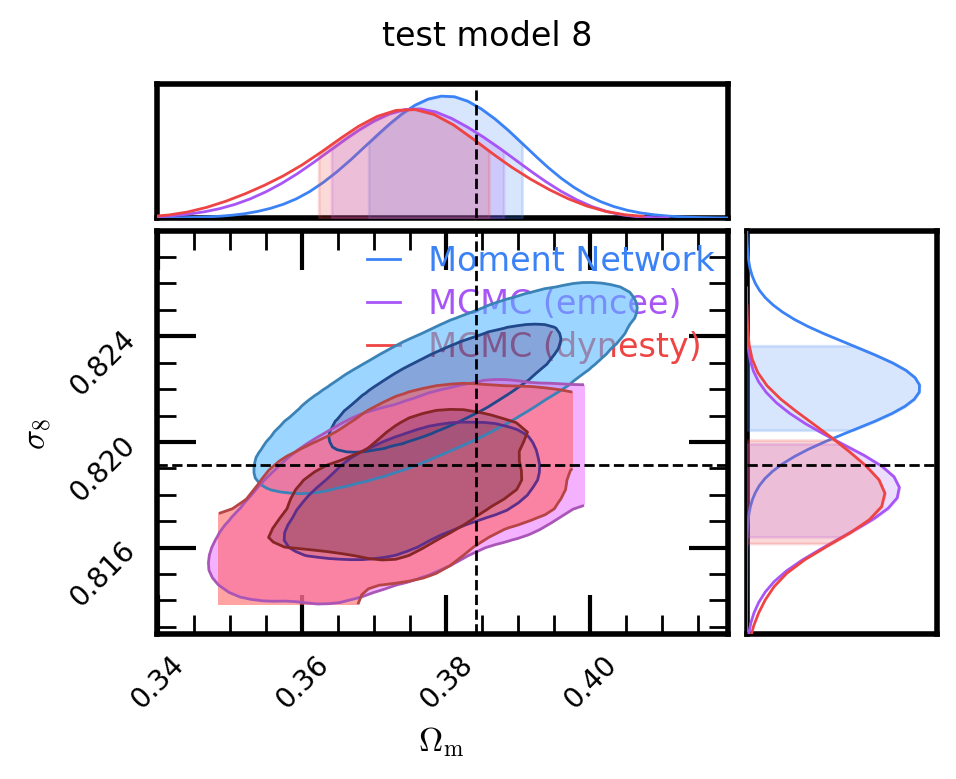

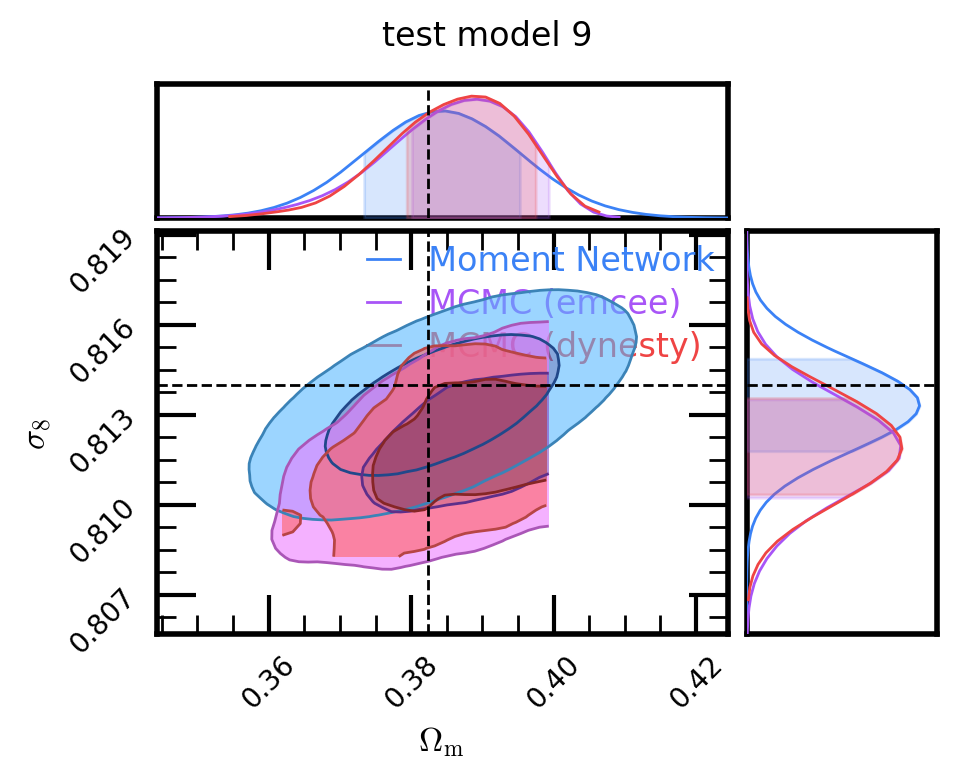

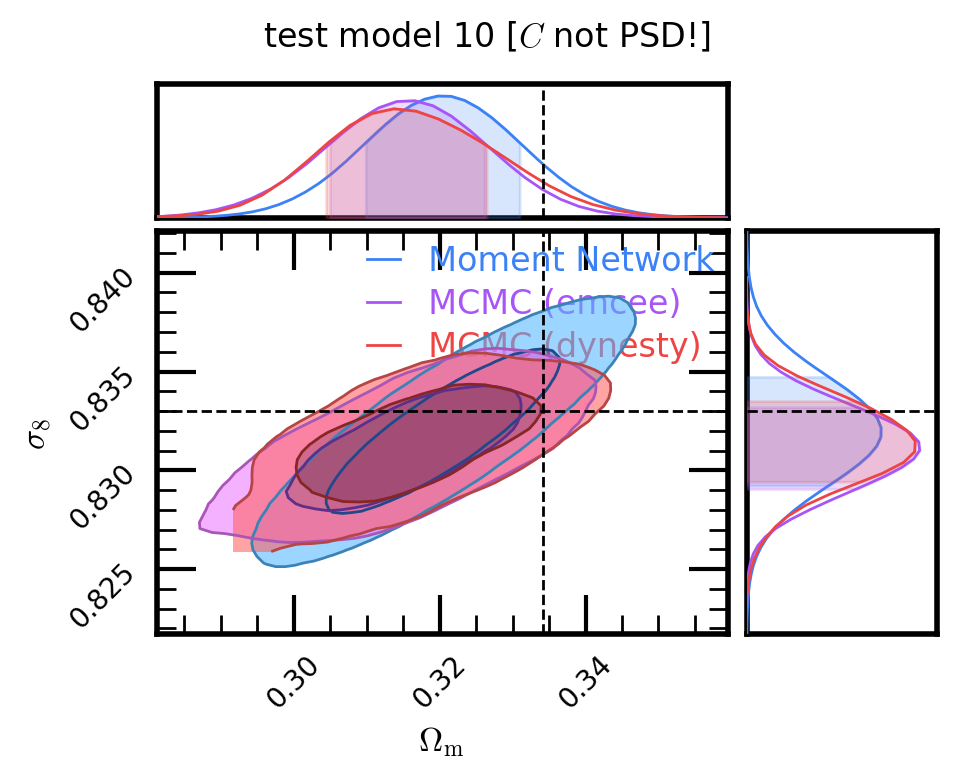

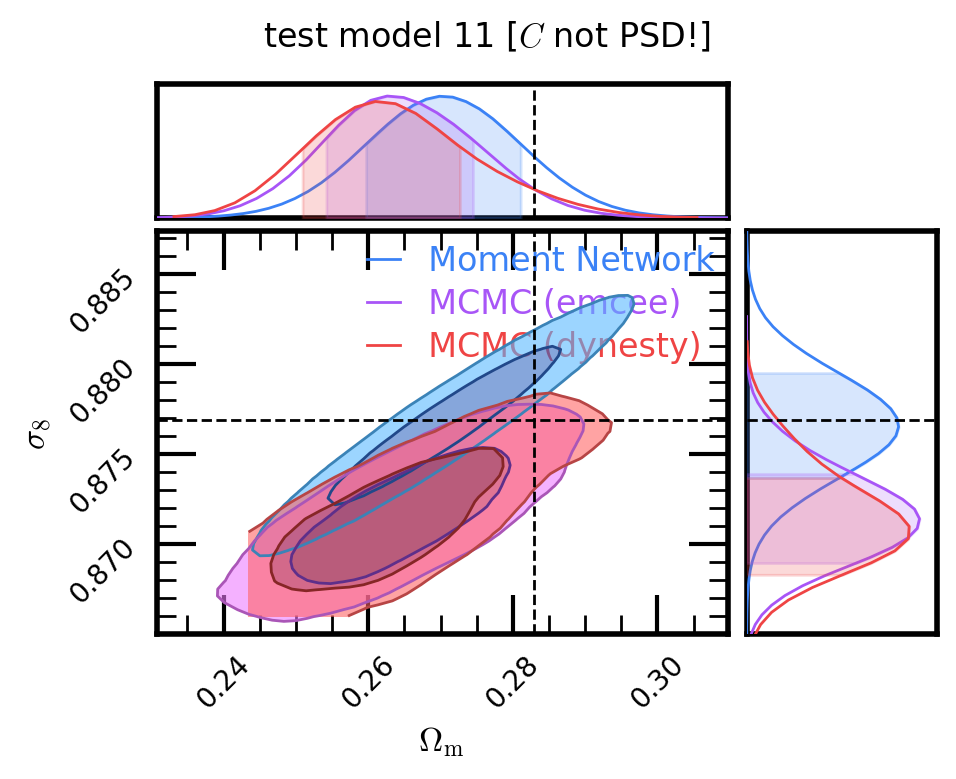

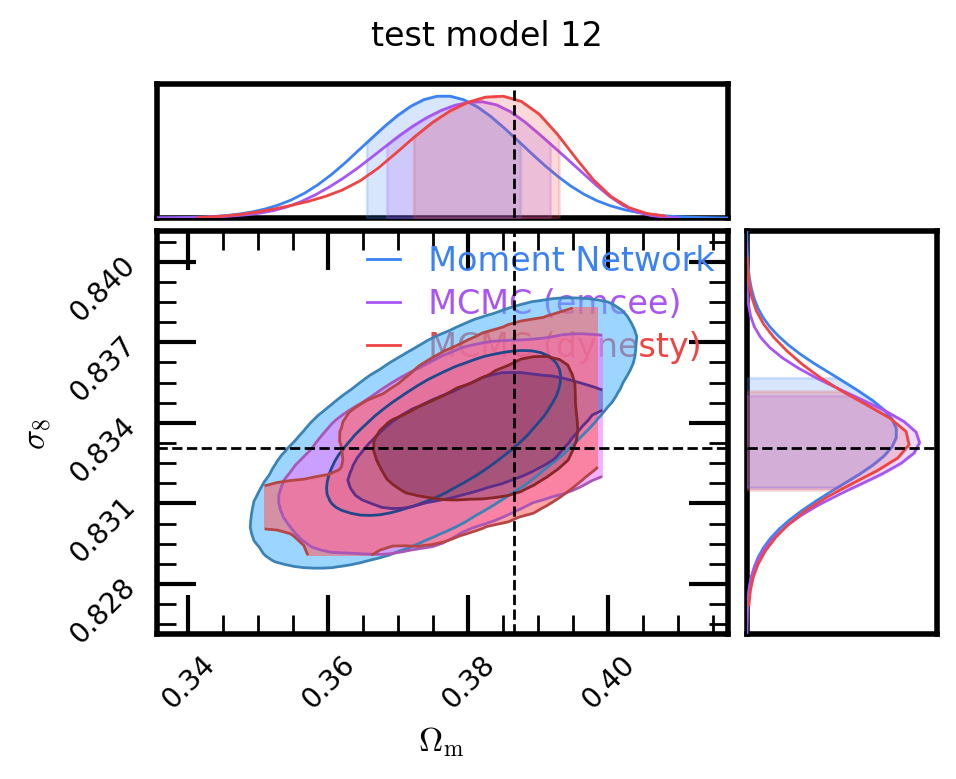

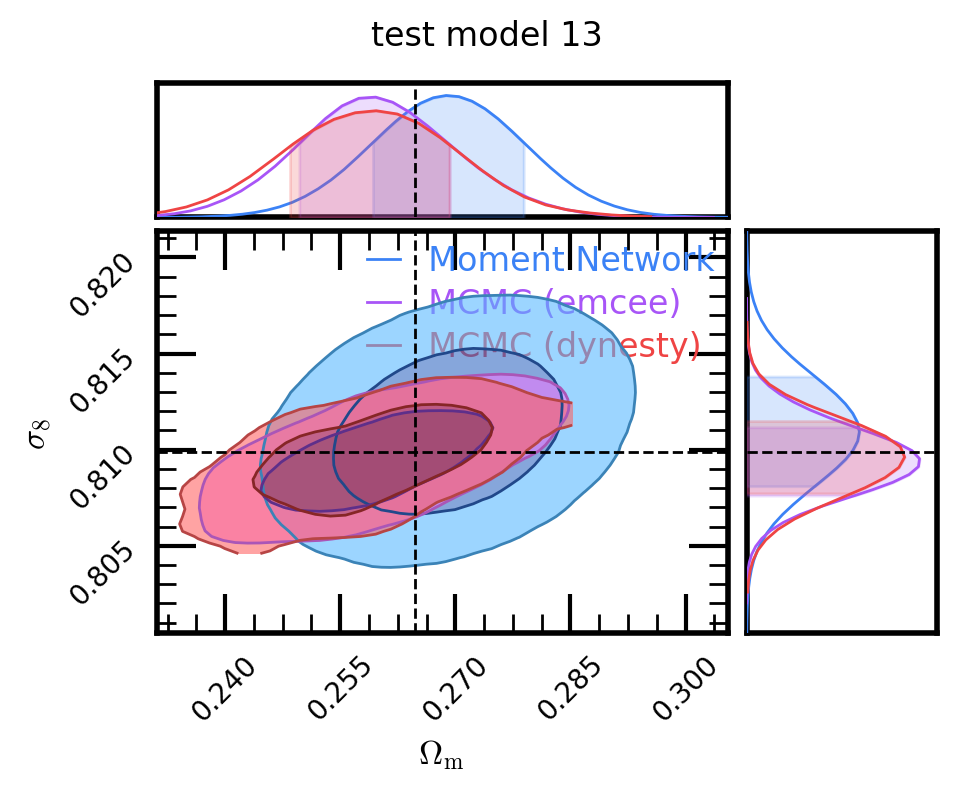

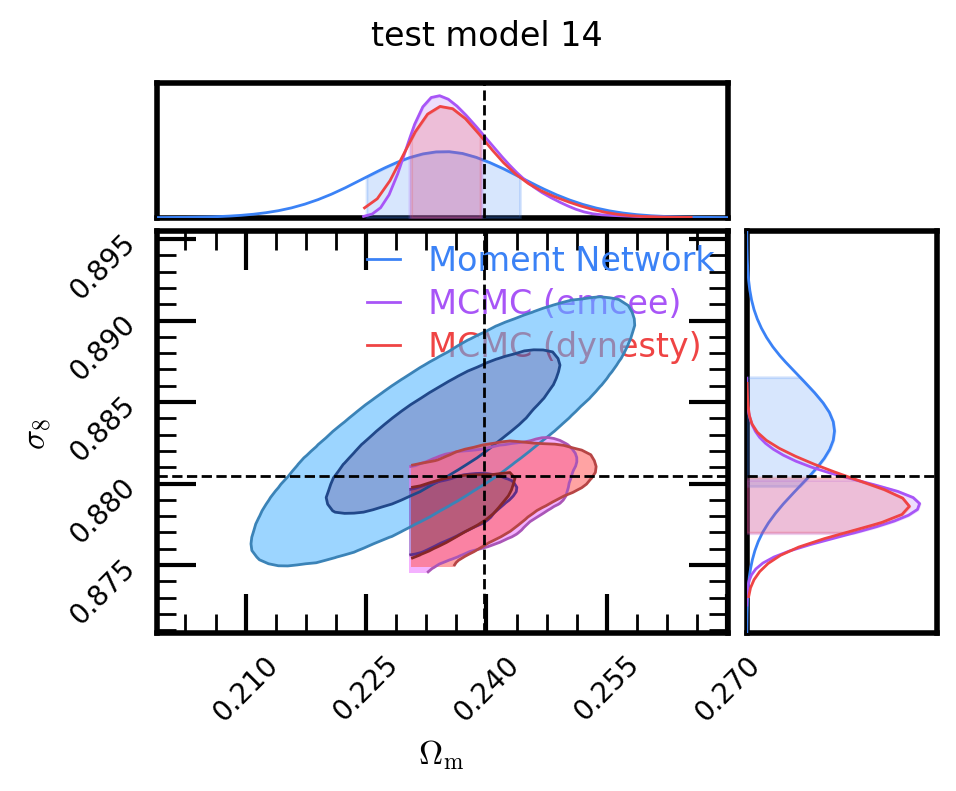

In [114]:
methods = ['mn', 'emcee', 'dynesty']
idxs_test = np.arange(15)
#idxs_test = [6]
tags_inf = [tag_inf]*len(methods)
tags_inf[-1] += '_nlive50'
for idx_test in idxs_test:
    plot_results(idx_test, methods, tags_inf)


### Compare emcee to moment

In [15]:
import re
dir_emcee =  f'../data/results_emcee/samplers{tag_inf}'
idxs_testsub = []
pattern = r'idxtest(\d+)'
for fn in os.listdir(dir_emcee):
    if fn.startswith("sampler_idxtest"):
        match = re.search(pattern, fn)
        idxs_testsub.append(int(match.group(1)))

In [16]:
idxs_testsub.remove(100)
idxs_testsub.remove(31)

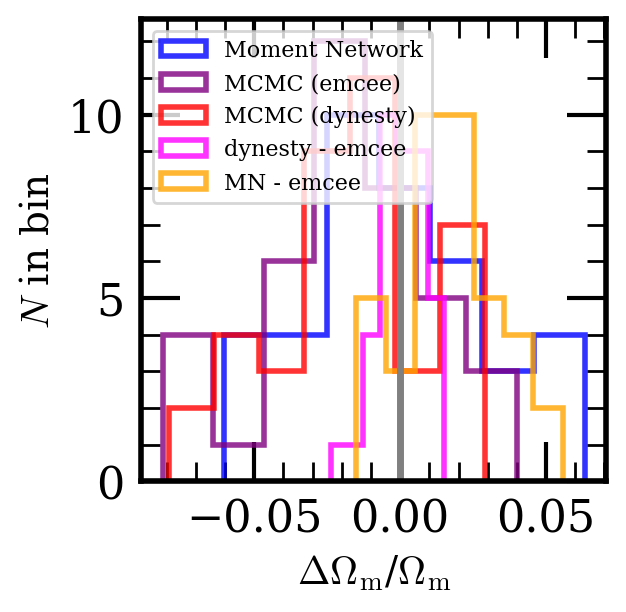

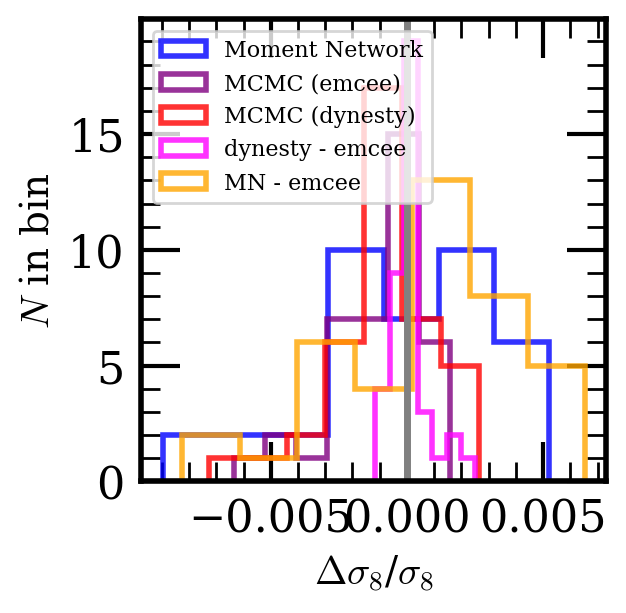

In [17]:
tag_inf_dynesty = tag_inf + '_nlive50'
dir_dynesty =  f'../data/results_dynesty/samplers{tag_inf_dynesty}'

theta_testsub = theta_test[idxs_testsub]
theta_testsub_pred_mn = theta_test_pred[idxs_testsub]
theta_testsub_pred_emcee = []
theta_testsub_pred_dynesty = []
for idx_testsub in idxs_testsub:
    #print(idx_testsub)
    
    ## EMCEE
    fn_emcee = f'{dir_emcee}/sampler_idxtest{idx_testsub}.npy'
    if not os.path.exists(fn_emcee):
        print(f'File {fn_emcee} not found')
        continue
    reader = emcee.backends.HDFBackend(fn_emcee)

    tau = reader.get_autocorr_time()
    n_burn = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    #print(n_burn, thin)
    samples_emcee = reader.get_chain(discard=n_burn, flat=True, thin=thin)
    theta_testsub_pred_emcee.append( utils.get_posterior_maxes(samples_emcee, param_names) )
    #log_prob_samples = reader.get_log_prob(discard=n_burn, flat=True, thin=thin)
    #idx_max_log_prob = np.argmax(log_prob_samples)
    #theta_testsub_pred_emcee.append(samples_emcee[idx_max_log_prob])

    ## DYNESTY
    fn_dynesty = f'{dir_dynesty}/sampler_results_idxtest{idx_testsub}.npy'
    results_dynesty = np.load(fn_dynesty, allow_pickle=True).item()
    #samples_dynesty = results_dynesty.samples_equal()
    
    from dynesty.utils import resample_equal
    # draw posterior samples
    weights = np.exp(results_dynesty['logwt'] - results_dynesty['logz'][-1])
    samples_dynesty = resample_equal(results_dynesty.samples, weights)
    theta_testsub_pred_dynesty.append( utils.get_posterior_maxes(samples_dynesty, param_names) )
    
theta_testsub_pred_emcee = np.array(theta_testsub_pred_emcee)
theta_testsub_pred_dynesty = np.array(theta_testsub_pred_dynesty)
    
fracdiffs_mn = (theta_testsub_pred_mn - theta_testsub)/theta_testsub
fracdiffs_emcee = (theta_testsub_pred_emcee - theta_testsub)/theta_testsub
fracdiffs_dynesty = (theta_testsub_pred_dynesty - theta_testsub)/theta_testsub
fracdiffs_dynesty_emcee = (theta_testsub_pred_dynesty - theta_testsub_pred_emcee)/theta_testsub_pred_emcee
fracdiffs_mn_emcee = (theta_testsub_pred_mn - theta_testsub_pred_emcee)/theta_testsub_pred_emcee

fracdiffs_arr = np.array([fracdiffs_mn, fracdiffs_emcee, fracdiffs_dynesty, 
                          fracdiffs_dynesty_emcee, fracdiffs_mn_emcee])
color_arr = [utils.color_dict_methods['mn'], utils.color_dict_methods['emcee'], 
             utils.color_dict_methods['dynesty'], 'magenta', 'orange']
label_arr = [utils.label_dict_methods['mn'], utils.label_dict_methods['emcee'], 
             utils.label_dict_methods['dynesty'], 'dynesty - emcee', 'MN - emcee']
plotter.plot_hists_mean(fracdiffs_arr, param_labels, 
                        color_arr=color_arr, label_arr=label_arr,
                        bins=7, alpha=0.8, histtype='step')


In [32]:
import re
tag_inf_dynesty = tag_inf + '_nlive50'
dir_dynesty =  f'../data/results_dynesty/samplers{tag_inf_dynesty}'
print(dir_dynesty)
idxs_testsub = []
pattern = r'idxtest(\d+)'
for fn in os.listdir(dir_dynesty):
    if "_idxtest" in fn:
        match = re.search(pattern, fn)
        idxs_testsub.append(int(match.group(1)))
print(len(idxs_testsub))

../data/results_dynesty/samplers_emuPk_2param_boxsize500_nlive50
193


(193, 2)
(193, 2)


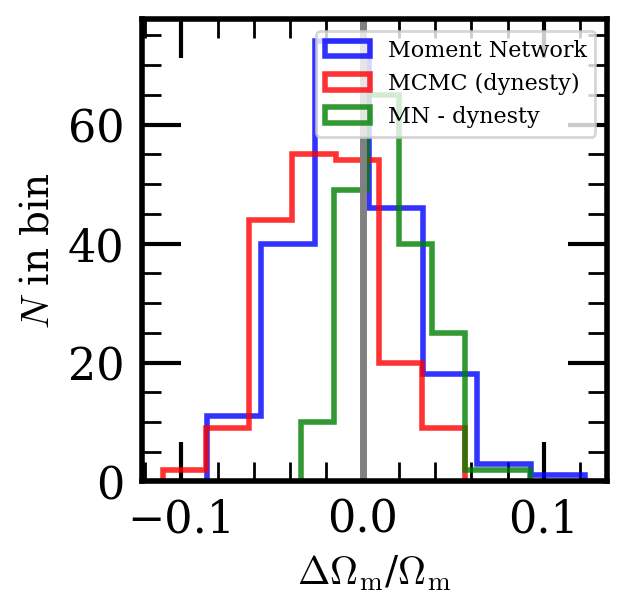

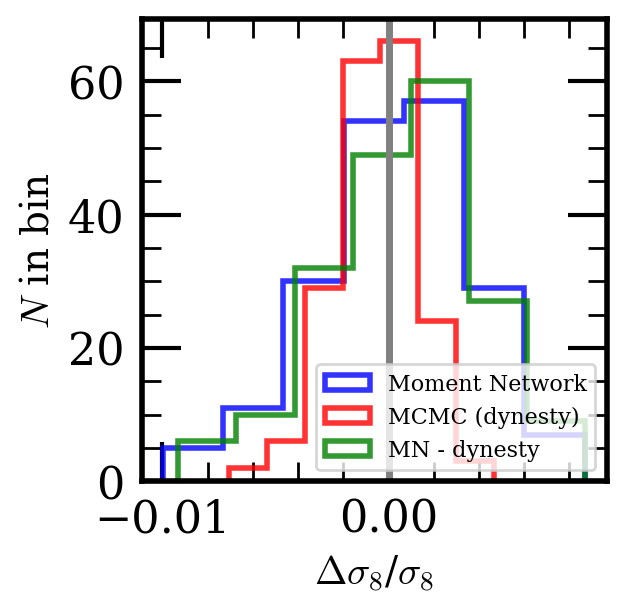

In [33]:

theta_testsub = theta_test[idxs_testsub]
theta_testsub_pred_mn = theta_test_pred[idxs_testsub]
theta_testsub_pred_dynesty = []
for idx_testsub in idxs_testsub:
    #print(idx_testsub)

    ## DYNESTY
    fn_dynesty = f'{dir_dynesty}/sampler_results_idxtest{idx_testsub}.npy'
    results_dynesty = np.load(fn_dynesty, allow_pickle=True).item()
    #samples_dynesty = results_dynesty.samples_equal()
    
    from dynesty.utils import resample_equal
    # draw posterior samples
    weights = np.exp(results_dynesty['logwt'] - results_dynesty['logz'][-1])
    samples_dynesty = resample_equal(results_dynesty.samples, weights)
    theta_testsub_pred_dynesty.append( utils.get_posterior_maxes(samples_dynesty, param_names) )
    
theta_testsub_pred_dynesty = np.array(theta_testsub_pred_dynesty)
    

print(theta_testsub.shape)
print(theta_testsub_pred_dynesty.shape)
    
fracdiffs_mn = (theta_testsub_pred_mn - theta_testsub)/theta_testsub
#fracdiffs_emcee = (theta_testsub_pred_emcee - theta_testsub)/theta_testsub
fracdiffs_dynesty = (theta_testsub_pred_dynesty - theta_testsub)/theta_testsub
#fracdiffs_dynesty_emcee = (theta_testsub_pred_dynesty - theta_testsub_pred_emcee)/theta_testsub_pred_emcee
fracdiffs_mn_dynesty = (theta_testsub_pred_mn - theta_testsub_pred_dynesty)/theta_testsub_pred_dynesty

fracdiffs_arr = np.array([fracdiffs_mn, fracdiffs_dynesty, 
                          fracdiffs_mn_dynesty])
color_arr = [utils.color_dict_methods['mn'], 
             utils.color_dict_methods['dynesty'], 'green']
label_arr = [utils.label_dict_methods['mn'],
             utils.label_dict_methods['dynesty'], 'MN - dynesty']
plotter.plot_hists_mean(fracdiffs_arr, param_labels, 
                        color_arr=color_arr, label_arr=label_arr,
                        bins=7, alpha=0.8, histtype='step')


In [42]:
# methods = ['mn', 'mn']
# idxs_obs = [6]
# tags_inf = [tag_inf]*2
# tags_inf[1] += '_ntrain4000'
# colors = ['blue', 'cyan']
# labels = ['n_train=800', 'n_train=4000']
# for idx_obs in idxs_obs:
#     plot_results(idx_obs, methods, tags_inf, colors=colors, labels=labels)
